### 安装

Google 提供的 BERT 代码在[这里](https://www.github.com/google-research/bert)，可以直接 git clone 下来。运行它需要 Tensorflow 1.11 及其以上的版本。

### 预训练模型

Google 提供了预训练的模型（checkpoint），目前包括英语、汉语和多语言三类模型：英语有多个版本，汉语只有一个版本：BERT-Base,Chinese，包括简体和繁体汉字，共 12 层，768 个隐单元，12 个 Attention Head，110M 参数。另外一个多语言的版本是 BERT-Base, Multilingual Cased，它包括 104 种不同语言，12 层，768 个隐单元，12 个 Attention Head，110M 参数。所有这些模型的下载地址在[这里](https://www.github.com/google-research/bert#pre-trained-models)。每个模型 .zip 文件包含三个部分：
* bert_model.ckpt：预训练权重（实际上是三个文件）
* vocab.txt：映射 WordPiece 到 word id
* bert_config.json：模型的超参（不需要修改）

### 运行 Fine-Tuning

对于大部分情况，不需要重新训练。我们要做的只是根据具体的任务进行 fine-tuning，这里以 GLUE 的 MRPC 为例子，我们首先需要下载预训练的模型然后解压，比如解压后的位置是：
```
export BERT_BASE_DIR=/home/model/uncased_L-12_H-768_A-12
```

接下来下载 GLUE 数据，可以使用这个[脚本](https://gist.github.com/W4ngatang/60c2bdb54d156a41194446737ce03e2e)下载，可能需要代理。假设下载后的位置是：
```
export GLUE_DIR=/home/data/glue_data
```

GLUE 中 MRPC 任务的格式为：
```
index  #1 ID  #2 ID  #1 String  #2 String
0  1089874  1089925  string1  string2
1  3019446  3019327  string1  string2
```

数据是 tsv 文件，每行有 4 个用 Tab 分割的字段，分别表示 index，第一个句子的 id，第二个句子的 id，第一个句子，第二个句子。也就是输入两个句子，模型判断它们是否是同一个意思。如果是测试数据，那么第一列就是 index（无意义），如果是训练数据，那么第一列就是 0 或者 1，其中 0 表示不同，1 表示相同。接下来可以运行以下命令来进行 fine-tuning:
```
python run_classifier.py \
    --task_name=MRPC \
    --do_train=true \
    --do_eval=true \
    --data_dir=$GLUE_DIR/MRPC \
    --vocab_file=$BERT_BASE_DIR/vocab.txt \
    --bert_config_file=$BERT_BASE_DIR/bert_config.json \
    --init_checkpoint=$BERT_BASE_DIR/bert_model.ckpt \
    --max_seq_length=128 \
    --train_batch_size=8 \
    --learning_rate=2e-5 \
    --num_train_epochs=3.0 \
    --output_dir=/tmp/mrpc_output/
```

简单介绍下参数的含义：
* task_name：任务的名字
* do_train：是否训练
* do_eval：是否在训练结束后验证
* data_dir：训练数据目录，配置了环境变量后不需要修改，否则填入绝对路径
* vocab_file：BERT 模型的词典
* bert_config_file：BERT 模型的配置文件
* init_checkpoint：fine-tuning 的初始化参数
* max_seq_length：token 序列的最大长度，这里是 128
* train_batch_size：batch 大小，对于普通的 8GB 的 GPU，最大 batch 大小只能是 8，再大就会 OOM
* learning_rate：学习率
* num_train_epochs：训练的 epoch 次数，根据任务进行调整
* output_dir：训练得到的模型的存放目录

这里最常见的问题是内存不够，通常我们的 GPU 只有 8G 左右的显存，因此对于小的模型（bert-base），最多使用 batchsize=8，而如果要使用 bert-large，那么 batchsize 只能设置为 1。运行结束可能得到类似如下的结果：
```
***** Eval results *****
eval_accuracy = 0.845588
eval_loss = 0.505248
global_step = 343
loss = 0.505248
```

这说明验证集上的准确率为 0.84 左右。

### DataProcessor

DataProcessor 是一个抽象基类，定义了 get_train_examples、get_dev_examples、get_test_examples,、get_labels 等 4 个需要子类实现的方法，另外还提供了一个 _read_tsv 函数用于读取 tsv 文件。下面我们通过一个实现类 MrpcProcessor 来了解怎么实现这个抽象基类。如果想使用自己的数据，就需要自己实现一个子类。

### MrpcProcessor

In [ ]:
class MrpcProcessor(DataProcessor):
    """Processor for the MRPC data set (GLUE vesion)"""
    def get_train_examples(self, data_dir):
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")
    
    def get_dev_examples(self, data_dir):
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")
    
    def get_test_examples(self, data_dir):
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "test.tsv")), "test")
    
    def get_labels(self):
        return ["0", "1"]
    
    def _create_examples(self, lines, set_type):
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, i)
            text_a = tokenization.convert_to_unicode(line[3])
            text_b = tokenization.convert_to_unicode(line[4])
            if set_type == "test":
                label = "0"
            else:
                label = tokenization.convert_to_unicode(line[0])
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
        return examples

如果是训练集和验证集，那么第一列 line[0] 就是真正的 label，而如果是测试集，label 没有意义，随便设为 "0"。然后对于所有的字符都使用 tokenization.convert_to_unicode 把字符串变成 unicode 的字符串。这是为了兼容 Python2 和 Python3，因为 Python3 的 str 就是 unicode，而 Python2 的 str 其实是 bytearray。

最终构造出一个 InputExample 对象来，它有四个属性：guid、text_a、text_b、label。guid 只是个唯一的 id 而已，text_a 代表第一个句子，text_b 代表第二个句子，第二个句子可以为 None，label 代表类标签。

### 分词

如果想要把 BERT 产品化，我们需要使用 Tensorflow Serving，Tensorflow Serving 的输入是 Tensor，把原始输入变成 Tensor 一般需要在 Client 端完成。BERT 的分词是 Python 的代码，如果我们使用其它语言的 gRPC Client，那么需要用其它语言实现同样的分词算法，否则预测时会出现问题。

#### FullTokenizer

BERT 里分词主要是由 FullTokenizer 类来实现的。

In [3]:
class FullTokenizer(object):
    def __init__(self, vocab_file, do_lower_case=True):
        self.vocab = load_vocab(vocab_file)
        self.basic_tokenizer = BasicTokenizer(do_lower_case=do_lower_case)
        self.wordpiece_tokenizer = WordpieceTokenizer(vocab=self.vocab)
        
    def tokenize(self, text):
        split_tokens = []
        for token in self.basic_tokenizer.tokenize(text):
            for sub_token in self.wordpiece_tokenizer.tokenize(token):
                split_tokens.append(sub_token)
        return split_tokens
    
    def convert_tokens_to_ids(self, tokens):
        return convert_tokens_to_ids(self.vocab, tokens)

FullTokenizer 的构造函数需要传入参数词典 vocab_file 和 do_lower_case。如果我们自己从头开始训练模型，那么 do_lower_case 决定了我们的模型是否区分大小写。如果只是 fine-tuning，这个参数需要与模型一致，比如模型是 uncased_L-12_H-768_A-12，那么 do_lower_case 就必须为 True。

函数首先调用 load_vocab 加载词典，建立词到 id 的映射关系。接下来是构造 BasicTokenizer 和 WordpieceTokenizer，前者是根据空格等进行普通分词，而后者会把前者的结果再细粒度切分为 WordPiece。首先来看 BasicTokenizer 的 tokenize 方法：

In [4]:
def tokenize(self, text):
    text = convert_to_unicode(text)
    text = self._clean_text(text)
    
    # 这是2018年11月1日为了支持多语言和中文增加的代码。这个代码也可以用于英文模型，因为在英语的训练预料中基本不会出现中文字符。
    text = self._tokenize_chinese_chars(text)
    
    orig_tokens = whitespace_tokenize(text)
    split_tokens = []
    for token in orig_tokens:
        if self.do_lower_case:
            token = token.lower()
            token = self._run_strip_accents(token)
        split_tokens.extend(self._run_split_on_punc(token))
        
    output_tokens = whitespace_tokenize(" ".join(split_tokens))
    return output_tokens

首先调用 convert_to_unicode 把输入变成 unicode，然后用 _clean_text 函数，它的作用是去除一些无意义的字符。

In [5]:
def _clean_text(self, text):
    """去除一些无意义的字符以及 whitespace"""
    output = []
    for char in text:
        cp = ord(char)  # 返回字符的 ASCII 数值，或者 Unicode 数值
        if cp == 0 or cp == 0xfffd or _is_control(char):  # cp 为 0 表示无意义的字符
            continue
        if _is_whitespace(char):
            output.append(" ")
        else:
            output.append(char)
    return "".join(output)

0xfffd 显示为 �，通常用于替换未知的字符。_is_control 用于判断一个字符是否是控制字符。

In [6]:
def _is_control(char):
    """检查字符是否是控制字符"""
    # 这里把回车换行和 tab 认为是 whitespace
    if char == "\t" or char == "\n" or char == "\r":
        return false
    cat = unicodedata.category(char)  # 这个函数返回 unicode 字符的 Category
    if cat in ("Cc", "Cf"):
        return True
    return False

接下来是调用 _is_whitespace 函数，把 whitespace 变成空格。

In [7]:
def _is_whitespace(char):
    """检查字符是否是空格"""
    if char == " " or char == "\t" or char == "\n" or char == "\r":
        return True
    cat = unicodedata.category(char)
    if cat == "Zs":
        return True
    return False

这里把 category 为 Zs 的字符以及空格、tab、回车和换行当成 whitespace。然后是 _tokenize_chinese_chars，用于切分中文，这里的切分中文是把中文切分成一个一个的汉字。也就是在中文字符的前后加上空格，这样后续的分词流程会把每一个字符当成一个词。

In [8]:
def _tokenize_chinese_chars(self, text):
    """汉字周围加上空格"""
    output = []
    for char in text:
        cp = ord(char)
        if self._is_chinese_char(cp):
            output.append(" ")
            output.append(char)
            output.append(" ")
        else:
            output.append(char)
    return "".join(output)

这里的关键是调用 _is_chinese_char 函数，用于判断一个 unicode 字符是否是中文字符。

In [9]:
def _is_chinese_char(self, cp):
    if ((cp >= 0x4E00 and cp <= 0x9FFF) or  #
        (cp >= 0x3400 and cp <= 0x4DBF) or  #
        (cp >= 0x20000 and cp <= 0x2A6DF) or  #
        (cp >= 0x2A700 and cp <= 0x2B73F) or  #
        (cp >= 0x2B740 and cp <= 0x2B81F) or  #
        (cp >= 0x2B820 and cp <= 0x2CEAF) or
        (cp >= 0xF900 and cp <= 0xFAFF) or  #
        (cp >= 0x2F800 and cp <= 0x2FA1F)):  #
        return True

    return False

接下来是使用 whitespace 进行分词，这里通过 whitespace_tokenize 来实现：

In [10]:
def whitespace_tokenize(text):
    """Runs basic whitespace cleaning and splitting on a piece of text."""
    text = text.strip()
    if not text:
        return []
    tokens = text.split()
    return tokens

然后遍历每一个词，如果 do_lower_case=True，先用 lower() 函数变成小写，接着调用 _run_strip_accents 函数去除 accents：

In [11]:
def _run_strip_accents(self, text):
    """Strips accents from a piece of text."""
    text = unicodedata.normalize("NFD", text)
    output = []
    for char in text:
        cat = unicodedata.category(char)
        if cat == "Mn":
            continue
        output.append(char)
    return "".join(output)

处理完大小写和 accent 之后得到的 Token 通过函数 _run_split_on_punc 再次用标点切分。这个函数会对输入字符串用标点进行切分，返回一个 list，list 的每个元素都是一个 char，比如输入 he's，输出是 [[h,e],['],[s]]。

In [15]:
import unicodedata

def _run_split_on_punc(self, text):
    chars = list(text)
    i = 0
    start_new_word = True
    output = []
    while i < len(chars):
        char = chars[i]
        if _is_punctuation(char):
            output.append([char])
            start_new_word = True
        else:
            if start_new_word:
                output.append([])
            start_new_word = False
            output[-1].append(char)
        i += 1
    
    return ["".join(x) for x in output]

def _is_punctuation(char):
    """Checks whether `chars` is a punctuation character."""
    cp = ord(char)
    # We treat all non-letter/number ASCII as punctuation.
    # Characters such as "^", "$", and "`" are not in the Unicode
    # Punctuation class but we treat them as punctuation anyways, for
    # consistency.
    if ((cp >= 33 and cp <= 47) or (cp >= 58 and cp <= 64) or
        (cp >= 91 and cp <= 96) or (cp >= 123 and cp <= 126)):
        return True
    cat = unicodedata.category(char)
    if cat.startswith("P"):
        return True
    return False

In [18]:
print(_run_split_on_punc(None, "he's"))
print(_run_split_on_punc(None, "窗 前 明 月 光，疑 是 地 上 霜 。"))

['he', "'", 's']
['窗 前 明 月 光', '，', '疑 是 地 上 霜 ', '。']


#### WordpieceTokenizer

WordpieceTokenizer 的作用是把词再切分成更细粒度的 WordPiece。对于中文来说，WordpieceTokenizer 什么也不干，因为之前的分词已经是基于字符的了。一般情况下不需要自己重新生成 WordPiece，使用 BERT 模型里自带的就行。

WordpieceTokenizer 的代码为：

In [19]:
def tokenize(self, text):
    # 把一段文字切分成 word piece。这其实是贪心的最大正向匹配算法。
    # 比如：input = "unaffable", output = ["un", "##aff", "##able"]
    text = convert_to_unicode(text)
    
    output_tokens = []
    for token in whitespace_tokenize(text):
        chars = list(token)
        if len(chars) > self.max_input_chars_per_word:  # 200
            output_tokens.append(self.unk_token)
            continue
            
        is_bad = False
        start = 0
        sub_tokens = []
        while start < len(chars):
            end = len(chars)
            cur_substr = None
            while start < end:
                substr = "".join(chars[start:end])
                if start > 0:
                    substr = "##" + substr
                if substr in self.vocab:
                    cur_substr = substr
                    break
                end -= 1
            if cur_substr is None:
                is_bad = True
                break
            sub_tokens.append(cur_substr)
            start = end
            
        if is_bad:
            output_tokens.append(self.unk_token)
        else:
            output_tokens.extend(sub_tokens)
    return output_tokens

### run_classifier.py 的 main 函数

main 函数的主要代码为：

In [ ]:
main()
    
    bert_config = modeling.BertConfig.from_json_file(FLAGS.bert_config_file)  # 从 json file 中构建 BertConfig
    
    task_name = FLAGS.task_name.lower()  # 任务名
    processor = processors[task_name]()  # 根据任务名获取 processor
    label_list = processor.get_labels()
    
    tokenizer = tokenization.FullTokenizer(
        vocab_file=FLAGS.vocab_file, do_lower_case=FLAGS.do_lower_case)
    
    run_config = tf.contrib.tpu.RunConfig(
        cluster=tpu_cluster_resolver,
        master=FLAGS.master,
        model_dir=FLAGS.output_dir,
        save_checkpoints_steps=FLAGS.save_checkpoints_steps,
        tpu_config=tf.contrib.tpu.TPUConfig(
            iterations_per_loop=FLAGS.iterations_per_loop,
            num_shards=FLAGS.num_tpu_cores,
            per_host_input_for_training=is_per_host))
    
    train_examples = None
    num_train_steps = None
    num_warmup_steps = None
    if FLAGS.do_train:
        train_examples = processor.get_train_examples(FLAGS.data_dir)
        num_train_steps = int(
            len(train_examples) / FLAGS.train_batch_size * FALGS.num_train_epochs)
        num_warmup_steps = int(num_train_steps * FLAGS.warmup_proportion)
        
    model_fn = model_fn_builder(
        bert_config=bert_config,
        num_labels=len(label_list),
        init_checkpoint=FLAGS.init_checkpoint,
        learning_rate=FLAGS.learning_rate,
        num_train_steps=num_train_steps,
        num_warmup_steps=num_warmup_steps,
        use_tpu=FLAGS.use_tpu,
        use_one_hot_embeddings=FLAGS.use_tpu)
    
    # If TPU is not available, this will fall back to normal Estimator on CPU or GPU
    estimator = tf.contrib.tpu.TPUEstimator(
        use_tpu=FLAGS.use_tpu,
        model_fn=model_fn,
        config=run_config,
        train_batch_size=FLAGS.train_batch_size,
        eval_batch_size=FLAGS.eval_batch_size,
        predict_batch_size=FLAGS.predict_batch_size)
    
    if FLAGS.do_train:
        train_file = os.path.join(FLAGS.output_dir, "train.tf_record")
        file_based_convert_examples_to_features(
            train_examples, label_list, FLAGS.max_seq_length, tokenizer, train_file)
        
        train_input_fn = file_based_input_fn_builder(
            input_file=train_file,
            seq_length=FLAGS.max_seq_length,
            is_training=True,
            drop_remainder=True)
        estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
        
    if FLAGS.do_eval:
        eval_examples = processor.get_dev_examples(FLAGS.data_dir)
        eval_file = os.path.join(FLAGS.output_dir, "eval.tf_record")
        file_based_convert_examples_to_features(
            eval_examples, label_list, FLAGS.max_seq_length, tokenizer, eval_file)
        
        # This tells the estimator to run through the entire set.
        eval_steps = None
        
        eval_drop_remainder = True if FLAGS.use_tpu else False
        eval_input_fn = file_based_input_fn_builder(
            input_file=eval_file,
            seq_length=FLAGS.max_seq_length,
            is_training=False,
            drop_remainder=eval_drop_remainder)
        
        result = estimator.evaluate(input_fn=eval_input_fn, steps=eval_steps)
        
    if FLAGS.do_predict:
        predict_examples = processor.get_test_examples(FALGS.data_dir)
        predict_file = os.path.join(FLAGS.output_dir, "predict.tf_record")
        file_based_convert_examples_to_features(predict_examples, label_list,
                                               FLAGS.max_seq_length, tokenizer, predict_file)
        
        predict_drop_remainder = True if FLAGS.use_tpu else False
        predict_input_fn = file_based_input_fn_builder(
            input_file=predict_file,
            seq_length=FLAGS.max_seq_length,
            is_training=False,
            drop_remainder=predict_drop_remainder)
        
        result = estimator.predict(input_fn=predict_input_fn)

这里使用的是 Tensorflow 的 Estimator API。训练、验证和预测的代码都很相似，这里只介绍训练部分的代码。

首先是通过 file_based_convert_examples_to_features 函数把输入的 tsv 文件转换为 TFRecord 文件，便于 Tensorflow 处理。

In [20]:
def file_based_convert_examples_to_features(
    examples, label_list, max_seq_length, tokenizer, output_file):
    """Convert a set of 'InputExample's to a TFRecord file."""
    
    writer = tf.python_io.TFRecordWriter(output_file)
    
    for (ex_index, example) in enumerate(examples):
        feature = convert_single_example(ex_index, example, label_list,
                                        max_seq_length, tokenizer)
        
        def create_int_feature(values):
            f = tf.train.Feature(int64_list=tf.train.Int64List(value=list(values)))
            return f
        
        features = collections.OrderDict()
        features["input_ids"] = create_int_feature(feature.input_ids)
        features["input_mask"] = create_int_feature(feature.input_mask)
        features["segment_ids"] = create_int_feature(feature.segment_ids)
        features["label_ids"] = create_int_feature([feature.label_id])
        
        tf_example = tf.train.Example(features=tf.train.Features(feature=features))
        writer.write(tf_example.SerializeToString())

file_based_convert_examples_to_features 函数遍历每一个 example(InputExample 类的对象)。然后使用 convert_single_example 函数把每个 InputExample 对象变成 InputFeature。InputFeature 是一个存放特征的对象，它包括 input_ids, input_mask, segment_ids 和 label_id，这 4 个属性除了 label_id 是一个 int 之外，其它都是 int 的列表。因此调用 create_int_feature 函数时，label_id 需要构造一个只有一个元素的列表。最后构造 tf.train.Example 对象，然后写到 TFRecord 文件里。

这里的关键是 convert_single_example 函数，读懂了它就真正明白 BERT 把输入表示成向量的过程。

In [21]:
def convert_single_example(ex_index, example, label_list, max_seq_length, tokenizer):
    """Converts a single 'InputExample' into a single 'InputFeatures'."""
    
    label_map = {}
    for (i, label) in enumerate(label_list):
        label_map[label] = i
        
    tokens_a = tokenizer.tokenize(example.text_a)
    tokens_b = None
    if example.text_b:
        tokens_b = tokenizer.tokenize(example.text_b)
        
    if tokens_b:
        # 如果有 b，那么需要保留 3 个特殊 token: [CLS], [SEP], [SEP]
        # 如果两个序列加起来太长，需要裁剪
        _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
    else:
        # 没有 b，只需要保留 [CLS], [SEP] 两个特殊字符
        # 如果 token 太多，直接截取后面的部分
        if len(tokens_a) > max_seq_length - 2:
            tokens_a = tokens_a[0: max_seq_length - 2]
            
    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)
        
    if tokens_b:
        for token in tokens_b:
            tokens.append(token)
            segment_ids.append(1)
        tokens.append("[SEP]")
        segment_ids.append(1)
        
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    
    # The mask has 1 for real tokens and 0 for padding tokens.
    # Only real tokens are attended to.
    input_mask = [1] * len(input_ids)
    
    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)
        
    label_id = label_map[example.label]
    
    feature = InputFeatures(
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids,
        label_id=label_id,
        is_real_example=True)

    return feature

如果两个 token 序列的长度太长，那么需要去掉一些，这会用到 _truncate_seq_pair 函数：

In [22]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""
    
    # 每次从较长的 sequence 中去掉一个 token
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

这个函数比较简单，如果两个序列的长度小于 max_length，那么不用 truncate，否则在 tokens_a 和 tokens_b 中选择较长的那个裁掉最后那个 token，直到两个序列的长度小于等于 max_length。

对于 Estimator API 来说，最重要的是实现 model_fn 和 input_fn。我们先看 input_fn，它是由 file_based_input_fn_builder 构造出来的。代码如下：

In [23]:
def file_based_input_fn_builder(input_file, seq_length, is_training,
                               drop_remainder):
    name_to_features = {
        "input_ids": tf.FixedLenFeature([seq_length], tf.int64),
        "input_mask": tf.FixedLenFeature([seq_length], tf.int64),
        "segment_ids": tf.FixedLenFeature([seq_length], tf.int64),
        "label_ids": tf.FixedLenFeature([], tf.int64),
        "is_real_example": tf.FixedLenFeature([], tf.int64),
    }
    
    def _decode_record(record, name_to_features):
        # 把 record decode 成 Tensorflow example
        example = tf.parse_single_example(record, name_to_features)
        
        # tf.Example 只支持 tf.int64，TPU 只支持 tf.int32，所以把所有 int64 转为 int32
        for name in list(example.keys()):
            t = example[name]
            if t.dtype == tf.int64:
                t = tf.to_int32(t)
            example[name] = t
            
        return example
    
    def input_fn(params):
        """The actual input function."""
        batch_size = params["batch_size"]
        
        # 对于训练来说，会重复的并行读取和 shuffling
        # 对于验证，不需要 shuffling 和并行读取
        d = tf.data.TFRecordDataset(input_file)
        if is_training:
            d = d.repeat()
            d = d.shuffle(buffer_size=100)
        
        d = d.apply(
            tf.contrib.data.map_and_batch(
                lambda record: _decode_record(record, name_to_features),
                batch_size=batch_size,
                drop_remainder=drop_remainder))
        
        return d
    
    return input_fn

这个函数返回一个函数 input_fn。这个 input_fn 函数首先从文件得到 TFRecordDataset，然后根据是否训练来 shuffle 和重复读取。然后用 apply 函数对每一个 TFRecord 进行 map_and_batch，调用 _decode_record 函数对 record 进行 parsing。从而把 TFRecord 的一条 Record 变成 tf.Example 对象，这个对象包括了 input_ids 等 4 个用于训练的 Tensor。

接下来是 model_fn_builder，它用于构造 Estimator 使用的 model_fn，下面是它的主要代码：

In [24]:
def model_fn_builder(bert_config, num_labels, init_checkpoint, learning_rate,
                     num_train_steps, num_warmup_steps, use_tpu,
                     use_one_hot_embeddings):
    """Returns 'model_fn' closure for TPUEstimator"""
    
    # features 表示输入（特征），labels 表示输出
    def model_fn(features, labels, mode, params):
        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]
        
        is_training = (mode == tf.estimator.ModeKeys.TRAIN)
        
        # 创建 Transformer 模型，这是最主要的代码
        (total_loss, per_example_loss, logits, probabilities) = create_model(
            bert_config, is_training, input_ids, input_mask, segment_ids, label_ids,
            num_labels, use_one_hot_embeddings)
        
        tvars = tf.trainable_variables()
        
        # 从 checkpoint 恢复参数
        if init_checkpoint:
            (assignment_map, initialized_variable_names) = modeling.get_assignment_map_from_checkpoint(tvars, init_checkpoint)
            
            tf.train.init_from_checkpoint(init_checkpoint, assignment_map)
            
        output_spec = None
        # 构造训练的 spec
        if mode == tf.estimator.ModeKeys.TRAIN:
            train_op = optimization.create_optimizer(
                total_loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu)
            
            output_spec = tf.contrib.tpu.TPUEstimatorSpec(
                mode=mode,
                loss=total_loss,
                train_op = train_op,
                scaffold_fn=scaffold_fn)
        elif mode == tf.estimator.ModeKeys.EVAL:
            def metric_fn(per_example_loss, label_idds, logits):
                predictions = tf.argmax(logits, axis=-1, output_type=tf.int32)
                accuracy = tf.metrics.accuracy(label_ids, predictions)
                loss = tf.metrics.mean(per_example_loss)
                return {
                    "eval_accuracy": accuracy,
                    "eval_loss": loss,
                }
            
            eval_metrics = (metric_fn, [per_example_loss, label_ids, logits])
            output_spec = tf.contrib.tpu.TPUEstimatorSpec(
                mode=mode,
                loss=total_loss,
                eval_metrics=eval_metrics,
                scaffold_fn=scaffold_fn)
        else:
            output_spec = tf.contrib.tpu.TPUEstimatorSpec(
                mode=mode,
                predictions=probabilities,
                scaffold_fn=scaffold_fn)
        return output_spec
    return model_fn

这里的代码都是一些模板代码，没什么可说的。最重要的是调用 create_model 创建 Transformer 模型。下面我们来看这个函数的代码：

In [25]:
def create_model(bert_config, is_training, input_ids, input_mask, segment_ids,
                 labels, num_labels, use_one_hot_embeddings):
    """创建分类模型"""
    model = modeling.BertModel(
        config=bert_config,
        is_training=is_training,
        input_ids=input_ids,
        input_mask=input_mask,
        token_type_ids=segment_ids,
        use_one_hot_embeddings=use_one_hot_embeddings)
    
    # 在这里，我们是用来做分类，因此只需得到 [CLS] 最后一层的输出
    # 如果需要做序列标注，就需要使用 model.get_sequence_output()
    # 默认参数下，它返回的 output_layer 是 [8, 768]
    output_layer = model.get_pooled_output()
    
    # 默认是 768
    hidden_size = output_layer.shape[-1].value
    
    output_weights = tf.get_variable(
        "output_weights", [num_labels, hidden_size],
        initializer=tf.truncated_normal_initializer(stddev=0.02))
    
    output_bias = tf.get_variable(
        "output_bias", [num_labels], initializer=tf.zeros_initializer())
    
    with tf.variable_scope("loss"):
        if is_training:
            # 0.1 的 dropout
            output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)
            
        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        probabilities = tf.nn.softmax(logits, axis=-1)
        log_probs = tf.nn.log_softmax(logits, axis=-1)
        
        one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)
        per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        loss = tf.reduce_mean(per_example_loss)
        
        return (loss, per_example_loss, logits, probabilities)
    

上面的代码调用 modeling.BertModel 得到 Bert 模型，然后调用它的 get_pooled_output 方法得到 [CLS] 最后一层的输出，这是一个 768（默认参数下）的向量，然后就是接一个全连接层得到 logits，softmax 计算得到概率，之后就可以根据真实的分类标签计算 loss。关键的代码就是 modeling.BertModel。

### BertModel 类

这个类是最终定义模型的地方。我们首先来看这个类的用法，把它当成黑盒，下面的代码演示了 BertModel 的使用方法。

In [ ]:
# 假设输入已经分词并且变成 Wordpiece 的 id 了，输入是 [2, 3]，表示 batch_size=2, max_seq_length=3
input_ids = tf.constant([[31, 51, 99], [15, 5, 0]])
# 第一个例子的实际长度是 3，第二个例子的实际长度是 2
input_mask = tf.constant([[1, 1, 1], [1, 1, 0]])
# 第一个例子的 3 个 token 中前两个属于句子 1，第三个属于句子 2；第二个例子的第一个 token 属于句子 1，第二个属于句子 2，第三个是 padding
token_type_ids = tf.constant([[0, 0, 1], [0, 1, 0]])

# 创建一个 BertConfig，词典大小是 32000，Transformer 的隐单元个数是 512，
# 8 个 Transformer block，每个 block 有 8 个 Attention Head，全连接层的隐单元是 1024
config = modeling.BertConfig(vocab_size=32000, hidden_size=512,
                             num_hidden_layers=8, num_attention_heads=6, intermediate_size=1024)

# 创建 BertModel
model = modeling.BertModel(config=config, is_training=True,
                           input_ids=input_ids, input_mask=input_mask, token_type_ids=token_type_ids)

label_embeddings = tf.get_variable(...)
pooled_output = model.get_pooled_output()
logits = tf.matmul(pooled_output, label_embeddings)
...

接下来我们看一下 BertModel 的构造函数：

In [ ]:
class BertModel(object):
    """BERT model"""
    def __init__(self,
                 config,
                 is_training,
                 input_ids,
                 input_mask=None,
                 token_type_ids=None,
                 use_one_hot_embeddings=False,
                 scope=None):
        """Constructor for BertModel.
        
        Args:
          config: 'BertConfig' instance.
          is_training: bool 值，表示是训练还是 eval，控制是否应用 dropout
          input_ids: int32 的 Tensor，shape 为 [batch_size, seq_length]
          input_mask: 可选，int32 的 Tensor，shape 为 [batch_size, seq_length]
          token_type_ids: 可选，int32 的 Tensor，shape 为 [batch_size, seq_length]
          use_one_hot_embeddings: 可选，bool 值。如果是 True，使用矩阵乘法实现提取词的 embedding，否则使用 tf.embedding_lookup()；
                                  对于 TPU，前者更快，对于 GPU，CPU，后者更快
          scope: 可选，变量的 scope，默认是 bert
          
        Raises:
          ValueError: The config is invalid or one of the input tensor shapes is invalid
        """
        config = copy.deepcopy(config)
        if not is_training:
            config.hidden_dropout_prob = 0.0
            config.attention_probs_dropout_prob = 0.0
            
        input_shape = get_shape_list(input_ids, expected_rank=2)
        batch_size = input_shape[0]
        seq_length = input_shape[1]
        
        if input_mask is None:
            input_mask = tf.ones(shape=[batch_size, seq_length], dtype=tf.int32)  # 设为全 1 矩阵
        if token_type_ids is None:
            token_type_ids = tf.zeros(shape=[batch_size, seq_length], dtype=tf.int32)  # 设为全 0，表示都属于一个句子
            
        with tf.variable_scope(scope, default_name="bert"):
            with tf.variable_scope("embeddings"):
                # Perform embedding lookup on the word ids.
                (self.embedding_output, self.embedding_table) = embedding_lookup(
                    input_ids=input_ids,
                    vocab_size=config.vocab_size,
                    embedding_size=config.hidden_size,
                    initializer_range=config.initializer_range,
                    word_embedding_name="word_embeddings",
                    use_one_hot_embeddings=use_one_hot_embeddings)
                
                # 增加位置 embeddings 和 token type 的 embeddings，然后是 layer normalize 和 dropout。
                self.embedding_output = embedding_postprocessor(
                    input_tensor=self.embedding_output,
                    use_token_type=True,
                    token_type_ids=token_type_ids,
                    token_type_vocab_size=config.type_vocab_size,
                    token_type_embedding_name="token_type_embeddings",
                    use_position_embeddings=True,
                    position_embedding_name="position_embeddings",
                    initializer_range=config.initializer_range,
                    max_position_embeddings=config.max_position_embeddings,
                    dropout_prob=config.hidden_dropout_prob)
                
            with tf.variable_scope("encoder"):
                # 把 shape 为 [batch_size, seq_length] 的 2D mask 变成 shape 为 [batch_size, seq_length, seq_length] 的 3D mask
                # 用作 attention scores
                attention_mask = create_attention_mask_from_input_mask(
                    input_ids, input_mask)
                
                # Run the stacked transformer
                # 'sequence_output' shape = [batch_size, seq_length, hidden_size]
                self.all_encoder_layers = transformer_model(
                    input_tensor=self.embedding_output,
                    attention_mask=attention_mask,
                    hidden_size=config.hidden_size,
                    num_hidden_layers=config.num_hidden_layers,
                    num_attention_heads=config.num_attention_heads,
                    intermediate_size=config.intermediate_size,
                    intermediate_act_fn=get_activation(config.hidden_act),
                    hidden_dropout_prob=config.hidden_dropout_prob,
                    attention_probs_dropout_prob=config.attention_probs_dropout_prob,
                    initializer_range=config.initializer_range,
                    do_return_all_layers=True)
                
            # sequence_output 是最后一层的输出，shape 是 [batch_size, seq_length, hidden_size]
            self.sequence_output = self.all_encoder_layers[-1]
            
            # "pooler" 把 encoded sequence tensfor [batch_size, seq_length, hidden_size] 转化为
            # [batch_size, hidden_size]，这对 segment-level 的分类任务是必需的，因为我们需要固定维度表示的 segment
            with tf.variable_scope("pooler"):
                # 取第一个 token 对应的 hidden state
                # sequence_output[:, 0:1, :] 得到的是 [batch_size, 1, hidden_size]
                # 使用 squeeze 把第二维去掉
                first_token_tensor = tf.squeeze(self.sequence_output[:, 0:1, :], axis=1)
                self.pooled_output = tf.layers.dense(
                    first_token_tensor,
                    config.hidden_size,
                    activation=tf.tanh,
                    kernel_initializer=create_initializer(config.initializer_range))

代码很长，其实很简单。首先是对 config 深度拷贝一份，如果不是训练，把 dropout 都置为零。如果输入的 input_mask 为 None，就构造一个 shape 合适值全为 1 的 input_mask，这表示输入都是有效的；如果 token_type_ids 为 None，就构造一个 shape 合适并且值全为 0 的 tensor，表示所有 token 都属于第一个句子。

然后使用 embedding_lookup 函数构造词的 embedding，用 embedding_postprocessor 函数增加位置 embeddings 和 token type 的 embeddings，然后是 layer normalize 和 dropout。

接着用 transformer_model 函数构造多个 Transformer Sublayer 然后 stack 在一起。得到的 all_encoder_layers 是一个 list，长度是 num_hidden_layers（默认是 12），每一层对应一个值。每个值都是一个 shape 为 [batch_size, seq_length, hidden_size] 的 tensor。

self.sequence_output 是最后一层的输出，shape 是 [batch_size, seq_length, hidden_size]。first_token_tensor 是第一个 token ([CLS]) 最后一层的输出，shape 是 [batch_size, hidden_size]。最后对 self.sequence_output 再加一个线性变换，得到的 tensor 仍然是 [batch_size, hidden_size]。

embedding_lookup 函数用于实现 Embedding，它有两种方式：使用 tf.nn.embedding_lookup 和矩阵乘法（one_hot_embedding=True）。前者适合于 CPU 和 GPU，后者适合于 TPU。

In [27]:
def embedding_lookup(input_ids,
                     vocab_size,
                     embedding_size=128,
                     initializer_range=0.02,
                     word_embedding_name="word_embeddings",
                     use_one_hot_embeddings=False):
    """Looks up words embeddings for id tensor.
    
    Args:
      input_ids: int32 Tensor shape 为 [batch_size, seq_length]，表示 Wordpiece 的 id
      vocab_size: 词典大小
      embedding_size: word embeddings 的宽度
      initializer_range: float, 随机初始化的范围
      word_embedding_name: string, embedding 表的名称
      use_one_hot_embeddings: bool, 如果是 true，使用 one-hot 方法实现 embedding，否则使用 'tf.gather(tf.nn.embedding_lookup)'的方式
      
    Returns:
      float tensor, shape 为 [batch_size, seq_length, embedding_size]
    """
    
    # 这个函数假设输入的 shape 是 [batch_size, seq_length, num_inputs]
    # 普通的 embedding 一般假设输入是 [batch_size, seq_length]
    # 增加 num_inputs 是为了一次计算更多的 embedding，目前的代码没有用到，传入的 input_ids 都是 2 维的
    
    # 如果输入是 [batch_size, seq_length]，把它 reshape 成 [batch_size, seq_length, 1]
    if input_ids.shape.ndims == 2:
        input_ids = tf.expand_dims(input_ids, axis=[-1])
        
    embedding_table = tf.get_variable(
        name=word_embedding_name,
        shape=[vocab_size, embedding_size],
        initializer=create_initializer(initializer_range))
    
    flat_input_ids = tf.reshape(input_ids, [-1])  # 把 input_ids 铺平成 1-D 数组 [batch_size * seq_length]
    if use_one_hot_embeddings:
        one_hot_input_ids = tf.one_hot(flat_input_ids, depth=vocab_size)  # [batch_size * seq_length, vocab_size]
        output = tf.matmul(one_hot_input_ids, embedding_table)  # [batch_size * seq_length, embedding_size]
    else:
        output = tf.gather(embedding_table, flat_input_ids)  # [batch_size * seq_length, embedding_size]
        
    input_shape = get_shape_list(input_ids)
    
    # 把 output 变成 [batch_size, seq_length, num_inputs * embedding_size]
    output = tf.reshape(output, input_shape[0:-1] + [input_shape[-1] * embedding_size])
    
    return (output, embedding_table)

可以不用关心太多的细节，把这个函数当成黑盒，那么只需要知道如果输入 input_ids 为 [8, 128]，输出是 [8, 128, 768] 就可以了。

函数 embedding_postprocessor 的代码如下：

In [28]:
def embedding_postprocessor(input_tensor,
                            use_token_type=False,
                            token_type_ids=None,
                            token_type_vocab_size=16,
                            token_type_embedding_name="token_type_embeddings",
                            use_position_embeddings=True,
                            position_embedding_name="position_embeddings",
                            initializer_range=0.02,
                            max_position_embeddings=512,
                            dropout_prob=0.1):
    """对 word embedding 之后的 tensor 进行后处理
    Args:
      input_tensor: float tensor，shape 为 [batch_size, seq_length, embedding_size]
      use_token_type: bool. 是否增加 token_type_ids 的 embeddings
      token_type_ids:（可选）int32 tensor，shape 为 [batch_size, seq_length]，如果 use_token_type 为 true，则必须提供值
      token_type_vocab_size: int, token type 的个数，通常是 2
      token_type_embedding_name: string, Token type embedding 的名字
      use_position_embedding: bool, 是否使用位置 embedding
      position_embedding_name: string, 位置 embedding 的名字
      initializer_range: float，初始化范围
      max_position_embeddings: int，位置编码的最大长度，可以比最大序列长度大，但不能比它小
      dropout_prob: float, Dropout 概率
      
    Returns:
      float tensor shape 和 input_tensor 相同
    """
    input_shape = get_shape_list(input_tensor, expected_rank=3)
    batch_size = input_shape[0]
    seq_length = input_shape[1]
    width = input_shape[2]
    
    output = input_tensor
    
    if use_token_type:
        if token_type_ids is None:
            raise ValueError("'token_type_ids' must be specified if 'use_token_type' is True.")
        token_type_table = tf.get_variable(
            name=token_type_embedding_name,
            shape=[token_type_vocab_size, width],
            initializer=create_initializer(initializer_range))
        # 因为 token type 通常很小，所以直接用矩阵乘法（one-hot）更快
        flat_token_type_ids = tf.reshape(token_type_ids, [-1])  # [batch_size * seq_length]
        one_hot_ids = tf.one_hot(flat_token_type_ids, depth=token_type_vocab_size)  # [batch_size * seq_length, token_type_vocab_size]
        token_type_embeddings = tf.matmul(one_hot_ids, token_type_table)  # [batch_size * seq_length, width]
        token_type_embeddings = tf.reshape(token_type_embeddings,
                                           [batch_size, seq_length, width])
        output += token_type_embeddings
        
    if use_position_embeddings:
        assert_op = tf.assert_less_equal(seq_length, max_position_embeddings)  # 确保 seq_length <= max_position_embeddings
        with tf.control_dependencies([assert_op]):
            full_position_embeddings = tf.get_variable(
                name=position_embedding_name,
                shape=[max_position_embeddings, width],
                initializer=create_initializer(initializer_range))
            # position embedding 是学习的参数，我们用一个长序列长度 max_position_embeddings 来创建它。
            # 真实的序列长度可能比这个值小，为了提高训练速度，通过 tf.slice 取出 [0, 1, 2, ..., seq_length - 1] 的部分
            position_embeddings = tf.slice(full_position_embeddings, [0, 0],
                                           [seq_length, -1])
            num_dims = len(output.shape.as_list())  # 3
            
            # word embedding 之后的 tensor 是 [batch_size, seq_length, width]
            # 因为位置编码是于输入内容无关的，它的 shape 总是 [seq_length, width]
            # 我们无法把位置 embedding 加到 word embedding 上
            # 因此我们需要扩展位置编码为 [1, seq_length, width]
            # 然后通过 broadcasting 加上去
            position_broadcast_shape = []
            for _ in range(num_dims - 2):
                position_broadcast_shape.append(1)
            position_broadcast_shape.extent([seq_length, width])
            position_embeddings = tf.reshape(position_embeddings,
                                             position_broadcast_shape)
            output += position_embeddings
            
    output = layer_norm_and_dropout(output, dropout_prob)
    return output

create_attention_mask_from_input_mask 函数用于构造 Mask 矩阵。我们先了解以下它的作用然后再阅读其代码。比如调用它时的两个参数为：

In [29]:
input_ids = [[1, 2, 3, 0, 0],
             [1, 3, 5, 6, 1]]
input_mask = [[1, 1, 1, 0, 0],
              [1, 1, 1, 1, 1]]

表示这个 batch 有两个样本，第一个样本长度为 3，第二个样本长度为 5。在计算 self-attention 的时候每个样本都需要一个 Attention Mask 矩阵，表示每一个时刻可以 attend to 的范围，1 表示可以 attend，0 表示是 padding 的（或者在机器翻译的 decoder 中不能 attend to 未来的词）。对于上面的输入，这个函数返回一个 shape 为 [2, 5, 5] 的 tensor，分别代表两个 Attention Mask 矩阵。

In [ ]:
[
    [1, 1, 1, 0, 0],  # 它表示第 1 个词可以 attend to 3 个词
    [1, 1, 1, 0, 0],  # 它表示第 2 个词可以 attend to 3 个词
    [1, 1, 1, 0, 0],  # 它表示第 3 个词可以 attend to 3 个词
    [1, 1, 1, 0, 0],  # 无意义，因为输入第 4 个词是 padding
    [1, 1, 1, 0, 0]   # 无意义，因为输入第 5 个词是 padding
]
[
    [1, 1, 1, 1, 1],  # 它表示第 1 个词可以 attend to 5 个词
    [1, 1, 1, 1, 1],  # 它表示第 2 个词可以 attend to 5 个词
    [1, 1, 1, 1, 1],  # 它表示第 3 个词可以 attend to 5 个词
    [1, 1, 1, 1, 1],  # 它表示第 4 个词可以 attend to 5 个词
    [1, 1, 1, 1, 1],  # 它表示第 5 个词可以 attend to 5 个词
]

In [30]:
def create_attention_mask_from_input_mask(from_tensor, to_mask):
    """Create 3D attention mask from a 2D tensor mask.
    
    Args:
      form_tensor: 2D or 3D tensor，shape 为 [batch_size, from_seq_length, ...]
      to_mask: int32 tensor, shape 为 [batch_size, to_seq_length]
      
    Returns:
      float tensor, shape 为 [batch_size, from_seq_length, to_seq_length]
    """
    from_shape = get_shape_list(from_tensor, expected_rank=[2, 3])
    batch_size = from_shape[0]
    from_seq_length = from_shape[1]
    
    to_shape = get_shape_list(to_mask, expected_rank=2)
    to_seq_length = to_shape[1]
    
    to_mask = tf.cast(
        tf.reshape(to_mask, [batch_size, 1, to_seq_length]), tf.float32)
    
    broadcast_ones = tf.ones(
        shape=[batch_size, from_seq_length, 1], dtype=tf.float32)
    
    mask = broadcast_ones * to_mask
    
    return mask

接下来是 transformer_model 函数，它是构造 Transformer 的核心代码。

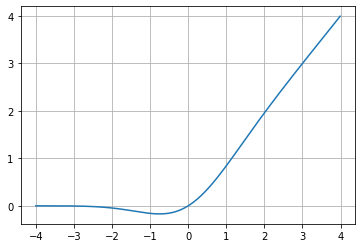

In [43]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def gelu(x):
    """Gaussian Error Linear Unit"""
    cdf = 0.5 * (1.0 + tf.tanh(
      (np.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3)))))
    return x * cdf

sess = tf.InteractiveSession()
t = np.arange(-4.0, 4.0, 0.01)
s = gelu(t)
fig, ax = plt.subplots()
ax.plot(t, s.eval())
ax.grid()
plt.show()
sess.close()

In [44]:
def transformer_model(input_tensor,
                      attention_mask=None,
                      hidden_size=768,
                      num_hidden_layers=12,
                      num_attention_heads=12,
                      intermediate_size=3072,
                      intermediate_act_fn=gelu,
                      hidden_dropout_prob=0.1,
                      attention_probs_dropout_prob=0.1,
                      initializer_range=0.02,
                      do_return_all_layers=False):
    """Multi-headed, multi-layer Transformer from 'Attention is all you need'.
    
    See the original paper:
    https://arxiv.org/abs/1706.03762

    Also see:
    https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/models/transformer.py
    
    Args:
      input_tensor: float Tensor, shape 为 [batch_size, seq_length, hidden_size]
      attention_mask: 可选，int32 Tensor, shape 为 [batch_size, seq_length, seq_length]，1 表示可以 attend to，0 不能
      hidden_size: int. Transformer 隐单元个数
      num_hidden_layers: int. 有多少个 layers (blocks)
      num_attention_heads: int. Transformer 中 attention heads 的个数
      intermediate_size: int. 全连接层的隐单元个数
      intermediate_act_fn: function. 全连接层的激活函数
      hidden_dropout_prob: float. 隐层的 dropout 概率
      attention_probs_dropout_prob: float. attention 的 dropout 概率
      initializer_range: float. 初始化范围
      do_return_all_layers: 返回所有层的输出还是最后一层的输出
      
    Returns:
      float tensor, shape 为 [batch_size, seq_length, hidden_size]
    """
    if hidden_size % num_attention_heads != 0:
        raise ValueError(
            "The hidden size (%d) is not a multiple of the number of attention"
            "heads (%d)" % (hidden_size, num_attention_heads))
        
    attention_head_size = int(hidden_size / num_attention_heads)
    input_shape = get_shape_list(input_tensor, expected_rank=3)
    batch_size = input_shape[0]
    seq_length = input_shape[1]
    input_width = input_shape[2]
    
    # Transformer 在所有层上进行残差连接，输入需要和 hidden_size 大小一致
    if input_width != hidden_size:
        raise ValueError("The width of the input tensor (%d) != hidden size (%d)" % (input_width, hidden_size))
        
    prev_output = reshape_to_matrix(input_tensor)
    
    all_layer_outputs = []
    for layer_index in range(num_hidden_layers):
        with tf.variable_scope("layer_%d" % layer_idx):
            layer_input = prev_output
            
            with tf.variable_scope("attention"):
                attention_heads = []
                with tf.variable_scope("self"):
                    attention_head = attention_layer(
                        from_tensor=layer_input,
                        to_tensor=layer_input,
                        attention_mask=attention_mask,
                        num_attention_heads=num_attention_heads,
                        size_per_head=attention_head_size,
                        attention_probs_dropout_prob=attention_probs_dropout_prob,
                        initializer_range=initializer_range,
                        do_return_2d_tensor=True,
                        batch_size=batch_size,
                        from_seq_length=seq_length,
                        to_seq_length=seq_length)
                    attention_heads.append(attentio_head)
                    
                attention_output = None
                if len(attention_heads) == 1:
                    attention_output = attention_heads[0]
                else:
                    # 如果有多个 head，需要把多个 head 的输出拼接起来
                    attention_output = tf.concat(attention_heads, axis=-1)
                    
                # Run a linear projection of 'hidden_size' then add a residual with 'layer_input'
                with tf.variable_scope("output"):
                    attention_output = tf.layers.dense(
                        attention_output,
                        hidden_size,
                        kernel_initializer=create_initializer(initializer_range))
                    attention_output = dropout(attention_output, hidden_dropout_prob)
                    attention_output = layer_norm(attention_output + layer_input)
                    
            # 这里就是 Transformer 里的 position-wise feed-forward network，包括两层全连接层
            # 只有这层有激活函数
            with tf.variable_scope("intermediate"):
                intermediate_output = tf.layers.dense(
                    attention_output,
                    intermediate_size,
                    activation=intermediate_act_fn,
                    kernel_initializer=create_initializer(initializer_range))
                
            # Down-project back to 'hidden_size' then add the residual
            with tf.variable_scope("output"):
                layer_output = tf.layers.dense(
                    intermediate_output,
                    hidden_size,
                    kernel_initializer=create_initializer(initializer_range))
                layer_output = dropout(layer_output, hidden_dropout_prob)
                layer_output = layer_norm(layer_output + attention_output)
                prev_output = layer_output
                all_layer_outputs.append(layer_output)
                
    if do_return_all_layers:
        final_outputs = []
        for layer_output in all_layer_outputs:
            final_output = reshape_from_matrix(layer_output, input_shape)
            final_outputs.append(final_output)
        return final_outputs
    else:
        final_output = reshape_from_matrix(prev_output, input_shape)
        return final_output

如果对照 Transformer 的论文，非常容易阅读，里面实现 Self-Attention 的函数就是 attention_layer。

In [45]:
def attention_layer(from_tensor,
                    to_tensor,
                    attention_mask=None,
                    num_attention_heads=1,
                    size_per_head=512,
                    query_act=None,
                    key_act=None,
                    value_act=None,
                    attention_probs_dropout_prob=0.0,
                    initializer_range=0.02,
                    do_return_2d_tensor=False,
                    batch_size=None,
                    from_seq_length=None,
                    to_seq_length=None):
    """Performs multi-headed attention from 'from_tensor' to 'to_tensor'.
    
    这是 Transformer 论文中 multi-headed 注意力的实现，如果 'from_tensor' 和 'to_tensor' 相同，那么就是 self-attention。
    每个时刻，'from_tensor' 都会 attends to 'to_tensor'，返回固定长度 vector。
    
    该函数首先把 'from_tensor' 变换为 "query" tensor，把 'to_tensor' 变换为 "key" "value" tensors，
    总共有 'num_attention_heads' 组 query, key, value，每个 tensor 的 shape 都是 [batch_size, seq_length, size_per_head]
    
    具体的实现和 Transformer 论文上说的一致。在实现时，multi-headed attention 是通过 transpose 和 reshape 实现的，而不是真的分割 tensors。
    
    Args:
      from_tensor: float Tensor, shape 为 [batch_size, from_seq_length, from_width].
      to_tensor: float Tensor，shape 为 [batch_size, to_seq_length, to_width].
      attention_mask:（可选）int32 Tensor，shape 为 [batch_size, from_seq_length, to_seq_length]，值可以是 0 或 1。
        在计算 attention score 的时候，会把 0 变成负无穷（绝对值很大的负数），而 1 不变，这样 softmax 的时候，前者会趋近于 0，从而实现 mask 的功能更
      num_attention_heads: int, Attention heads 的数量
      size_per_head: int. 每个 attention head 的大小
      query_act: (可选)，query 变换的激活函数
      key_act: (可选)，key 变换的激活函数
      value_act: （可选），value 变换的激活函数
      attention_probs_dropout_prob: （可选），attention 的 dropout 概率
      initializer_range: float, 初始化范围
      do_return_2d_tensor: bool, 如果是 True，返回的 shape 为 [batch_size * from_seq_length, num_attention_heads * size_per_head]
        如果是 False，返回 [batch_size, from_seq_length, num_attention_heads * size_per_head]
      batch_size: (可选)，如果输入是 3D 的，那么 batch 就是第一维，但是可能 3D 的压缩成了 2D，所以需要告诉函数 batch_size
      from_seq_length：（可选），同上，需要告诉函数 from_seq_length
      to_seq_length：（可选），同上。
      
    Returns:
      根据 do_return_2d_tensor 的值，返回不同维度的 tensor
    """
    
    def transpose_for_scores(input_tensor, batch_size, num_attention_heads,
                             seq_length, width):
        output_tensor = tf.reshape(
            input_tensor, [batch_size, seq_length, num_attention_heads, width])
        
        output_tensor = tf.transpose(output_tensor, [0, 2, 1, 3])
        return output_tensor
    
    from_shape = get_shape_list(from_tensor, expected_rank=[2, 3])
    to_shape = get_shape_list(to_tensor, expected_rank=[2, 3])
    
    if len(from_shape) != len(to_shape):
        raise ValueError(
            "The rank of 'from_tensor' must match the rank of 'to_tensor'.")
        
    if len(from_shape) == 3:
        batch_size = from_shape[0]
        from_seq_length = from_shape[1]
        to_seq_length = to_shape[1]
    elif len(from_shape) == 2:  #如果压缩成 2D 的，一定要传入这三个参数，否则抛异常
        if (batch_size is None or from_seq_length is None or to_seq_length is None):
            raise ValueError(
                "When passing in rank 2 tensors to attention_layer, the values "
                "for 'batch_size', 'from_seq_length', and 'to_seq_length' "
                "must all be specified.")
            
    # B = batch_size (number of sequences)
    # F = 'from_tensor' sequence length
    # T = 'to_tensor' sequence length
    # N = 'num_attention_heads'
    # H = 'size of head'
    
    from_tensor_2d = reshape_to_matrix(from_tensor)
    to_tensor_2d = reshape_to_matrix(to_tensor)
    
    # 'query_layer' = [B * F, N * H]
    query_layer = tf.layers.dense(
        from_tensor_2d,
        num_attention_heads * size_per_head,
        activation=query_act,
        name="query",
        kernel_initializer=create_initializer(initializer_range))
    
    # 'key_layer' = [B * T, N * H]
    key_layer = tf.layers.dense(
        to_tensor_2d,
        num_attention_heads * size_per_head,
        activation=key_act,
        name="key",
        kernel_initializer=create_initializer(initializer_range))
    
    # 'value_layer' = [B * T, N * H]
    value_layer = tf.layers.dense(
        to_tensor_2d,
        num_attention_heads * size_per_head,
        activation=value_act,
        name="value",
        kernel_initializer=create_initializer(initializer_range))
    
    # 'query_layer' = [B, N, F, H]
    query_layer = transpose_for_scores(query_layer, batch_size,
                                       num_attention_heads, from_seq_length,
                                       size_per_head)
    
    # 'key_layer' = [B, N, T, H]
    key_layer = transpose_for_scores(key_layer, batch_size, num_attention_heads,
                                     to_seq_length, size_per_head)
    
    # 计算 query 和 key 的内积，得到 attention scores
    # attention_scores = [B, N, F, T]
    attention_scores = tf.matmul(query_layer, key_layer, transpose_b=True)
    accention_scores = tf.multiply(attention_scores,
                                   1.0 / math.sqrt(float(size_per_head)))
    
    if attention_mask is not None:
        # 'attention_mask' = [B, 1, F, T]
        attention_mask = tf.expand_dims(attention_mask, axis=[1])
        
        # 如果 mask 是 1，那么 (1-1) * -10000=0，adder=0，如果 mask 是 0，那么 (1-0) * -10000=-10000，adder=-10000
        adder = (1.0 - tf.cast(attention_mask, tf.float32)) * -10000.0
        
        # 把 adder 加到 attention_scores，如果 mask 为 1 相当于加 0，mask 为 0 相当于加 -10000
        # 通常 attention_scores 不会很大，因此 mask 为 0 相当于把 attention_scores 设为负无穷，softmax 的时候值趋近于0
        attention_scores += adder
        
    # 'attention_probs' = [B, N, F, T]
    attention_probs = tf.nn.softmax(attention_scores)
    
    attention_probs = dropout(attention_probs, attention_probs_dropout_prob)

    # `value_layer` = [B, T, N, H]
    value_layer = tf.reshape(
        value_layer,
        [batch_size, to_seq_length, num_attention_heads, size_per_head])

    # `value_layer` = [B, N, T, H]
    value_layer = tf.transpose(value_layer, [0, 2, 1, 3])

    # `context_layer` = [B, N, F, H]
    context_layer = tf.matmul(attention_probs, value_layer)

    # `context_layer` = [B, F, N, H]
    context_layer = tf.transpose(context_layer, [0, 2, 1, 3])

    if do_return_2d_tensor:
        # `context_layer` = [B*F, N*H]
        context_layer = tf.reshape(
            context_layer,
            [batch_size * from_seq_length, num_attention_heads * size_per_head])
    else:
        # `context_layer` = [B, F, N*H]
        context_layer = tf.reshape(
            context_layer,
            [batch_size, from_seq_length, num_attention_heads * size_per_head])

    return context_layer

### 自己进行 Pretraining

虽然 Google 提供了 pretraining 的模型，我们也可以自己通过 mask LM 和 Next Sentence Prediction 进行 Pretraining。可以从头开始训练，也可以用 Google 提供的 checkpoint 作为初始值。

要进行 Pretraining 首选要有数据，数据由很多“文档”组成，每篇文档的句子之间是有关系的。如果只能拿到没有关系的句子则是无法训练的，训练数据需要变成如下的格式：

In [ ]:
This text is included to make sure Unicode is handled properly: 力加勝北区ᴵᴺᵀᵃছজটডণত
Text should be one-sentence-per-line, with empty lines between documents.
This sample text is public domain and was randomly selected from Project Guttenberg.

The rain had only ceased with the gray streaks of morning at Blazing Star, and the settlement awoke to a moral sense of cleanliness, and the finding of forgotten knives, tin cups, and smaller camp utensils, where the heavy showers had washed away the debris and dust heaps before the cabin doors.
Indeed, it was recorded in Blazing Star that a fortunate early riser had once picked up on the highway a solid chunk of gold quartz which the rain had freed from its incumbering soil, and washed into immediate and glittering popularity.
Possibly this may have been the reason why early risers in that locality, during the rainy season, adopted a thoughtful habit of body, and seldom lifted their eyes to the rifted or india-ink washed skies above them.
"Cass" Beard had risen early that morning, but not with a view to discovery.
......

数据是文本文件，每一行表示一个句子，空行表示一个文档的结束（新文档的开始），比如上面的例子，共有 2 篇文档，第一个文档有 3 个句子，第二个文档有多个句子。

我们首先需要使用 create_pretraining_data.py 把文本文件变成 TFRecord 格式，便于后面的代码进行 pretraing。这个脚本会把整个文本加载到内存中，因此这个文件不能太大。如果有很多文档需要训练，比如 1000万，那么可以把这 1000万文档拆分成 1万个文件，每个文件 1000 个文档，从而生成 1000 个 TFRecord 文件。

我们先看 create_pretraining_data.py 的用法：
```
python create_pretraining_data.py \
    --input_file=./sample_text.txt \
    --output_file=/tmp/tf_examples.tfrecord \
    --vocab_file=$BERT_BASE_DIR/vocab.txt \
    --do_lower_case=True \
    --max_seq_length=128 \
    --max_predictions_per_seq=20 \
    --masked_lm_prob=0.15 \
    --random_seed=12345 \
    --dupe_factor=5
```

* max_seq_length: Token 序列的最大长度
* max_predictions_per_seq: 最多生成多少个 mask
* masked_lm_prob: 多少比例的 token 变成 mask
* dupe_factor: 一个文档重复多少次

首先说一下 dupe_factor，比如一个句子 "it is a good day"，为了充分利用数据，我们可以多次随机生成 mask，比如第一次可能生成 "it is a [MASK] day"，第二次可能生成 "it [MASK] a good day"。这个参数控制重复的次数。

masked_lm_prob 就是论文里的参数 15%，max_predictions_per_seq 是一个序列最多 mask 多少个 token，它通常等于 max_seq_length * masked_lm_prob。

我们先看 main 函数：

In [46]:
def main(_):
    tokenizer = tokenization.FullTokenizer(
        vocab_file=FLAGS.vocab_file, do_lower_case=FLAGS.do_lower_case)
    
    input_files = []
    # input_file 可以传多个文件名，以 ',' 分隔
    for input_pattern in FLAGS.input_file.split(","):
        input_files.extend(tf.gfile.Glob(input_pattern))
        
    rng = random.Random(FLAGS.random_seed)
    instances = create_training_instances(
        input_files, tokenizer, FLAGS.max_seq_length, FLAGS.dupe_factor,
        FLAGS.short_seq_prob, FLAGS.masked_lm_prob, FLAGS.max_predictions_per_seq,
        rng)

    output_files = FLAGS.output_file.split(",")

    write_instance_to_example_files(instances, tokenizer, FLAGS.max_seq_length,
                                    FLAGS.max_predictions_per_seq, output_files)

main 函数很简单，输入文本文件列表是 input_files，通过函数 create_training_instance 构建训练的 instances，然后调用 write_instance_to_example_files 以 TFRecord 格式写到 output_files。

我们先来看一个训练样本的格式，这是用类 TrainingInstance 来表示的：

In [47]:
class TrainingInstance(object):
    """A single training instance (sentence pair)."""

    def __init__(self, tokens, segment_ids, masked_lm_positions, masked_lm_labels,
                 is_random_next):
        self.tokens = tokens
        self.segment_ids = segment_ids
        self.is_random_next = is_random_next
        self.masked_lm_positions = masked_lm_positions
        self.masked_lm_labels = masked_lm_labels

假设原始的两个句子为: "it is a good day" 和 "I want to go out"，那么处理后的 TrainingInstance 可能为：
```
1. tokens = ["[CLS]", "it", "is", "a", "[MASK]", "day", "[SEP]", "I", "apple", "to", "go", "out", "[SEP]"]
2. segment_ids=[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
3. is_random_next=False
4. masked_lm_position=[4, 8, 9]
  表示 mask 后为 ["[CLS]", "it", "is", "a", "[MASK]", "day", "[SEP]", "I", "[MASK]", "to", "go", "out", "[SEP]"]
5. masked_lm_labels=["good", "want", "to"]
```
is_random_next 表示这两句话是有关联的，预测句子关系的分类器应该把这个输入判断为 1。masked_lm_positions 记录哪些位置被 mask 了，而 masked_lm_labels 记录被 mask 之前的词。

注意：tokens 已经处理过了，good 被替换成 [MASK]，而 want 被替换成 apple，to 替换为它自己。根据 masked_lm_positions、masked_lm_labels 和 tokens 是可以恢复出原始（分词后）句子的。

create_training_instances 函数的代码为：

In [49]:
def create_training_instances(input_files, tokenizer, max_seq_length,
                              dupe_factor, short_seq_prob, masked_lm_prob,
                              max_predictions_per_seq, rng):
    """Create 'TrainingInstance' from raw text."""
    all_documents = [[]]
    
    # 输入文件格式：
    # （1）每行一个句子。这应该是实际的句子，不应该是整个段落或者段落的随机片段，
    #  因为我们需要使用句子边界来做下一个句子的预测。
    # （2）文档之间有一个空行。我们会认为同一个文档的相邻句子是有关系的
    for input_file in input_files:
        with tf.gfile.GFile(input_file, "r") as reader:
            while True:
                line = tokenization.convert_to_unidoce(reader.readline())
                if not line:
                    break
                line = line.strip()
                
                # 空行表示文档分隔符
                if not line:
                    all_documents.append([])
                tokens = tokenizer.tokenize(line)
                if tokens:
                    all_documents[-1].append(tokens)
                    
    # 删除空文档
    all_documents = [x for x in all_documents if x]
    rng.shuffle(all_documents)
    
    vocab_words = list(tokenizer.vocab.keys())
    instances = []
    for _ in range(dupe_factor):
        # 遍历所有文档
        for document_index in range(len(all_documents)):
            # 从一个文档里抽取多个 TrainingInstance
            instances.extend(
                create_instances_from_document(
                    all_documents, document_index, max_seq_length, short_seq_prob,
                    masked_lm_prob, max_predictions_per_seq, vocab_words, rng))
    
    rng.shuffle(instances)
    return instances

上面的代码会调用 create_instances_from_document 来从一个文档里抽取多个训练数据。普通的语言模型只要求连续的字符串就行，通常是把所有的文本（比如维基百科）拼接成一个很大很大的文本文件，然后训练的时候随机从里面抽取固定长度的字符串作为一个“句子”。但是 BERT 要求输入是一个一个的 document，每个 document 有很多句子，这些句子是连贯的真实句子，需要正确的分句。而不能随机切分句子，代码如下：

In [50]:
def create_instances_from_document(
    all_documents, document_index, max_seq_length, short_seq_prob,
    masked_lm_prob, max_predictions_per_seq, vocab_words, rng):
    """Creates 'TrainingInstance's for a single document."""
    document = all_documents[document_index]
    
    # 为 [CLS], [SEP], [SEP] 留 3 个位置
    max_num_tokens = max_seq_length - 3
    
    # 我们通常想要填充整个序列，因为不管怎样都要 padding 至 'max_seq_length'，这样短的序列会浪费资源，
    # 但有时候我们会希望生成一些短的句子，因为在实际中会有短句，如果都是长句子，那么就容易出现 mismatch，
    # 所以我们以 short_seq_prob=0.1 的概率生成短句子。
    target_seq_length = max_num_tokens
    if rng.random() < short_seq_prob:
        target_seq_length = rng.randint(2, max_num_tokens)
        
    # 不能把文档中的所有 token 拼接成一个长句子然后随机分割，这样使得下个句子预测太过容易，
    # 而是在真实句子中分割成 A 和 B。
    instances = []
    current_chunk = []
    current_length = 0
    i = 0
    while i < len(document):
        segment = document[i]
        current_chunk.append(segment)
        current_length += len(segment)
        if i == len(document) - 1 or current_length >= target_seq_length:
            if current_chunk:
                # 'a_end' 是第一个句子 A（current_chunk 里）结束的下标
                a_end = 1
                if len(current_chunk) >= 2:
                    a_end = rng.randint(1, len(current_chunk) - 1)
                    
                tokens_a = []
                for j in range(a_end):
                    tokens_a.extend(current_chunk[j])
                    
                tokens_b = []
                # Random next
                is_random_text = False
                if len(current_chunk) == 1 or rng.random() < 0.5:
                    is_random_next = True
                    target_b_length = target_seq_length - len(tokens_a)
                    
                    # 随机挑选另外一篇文档的随机开始的句子，为确保和当前文档不一样，这里循环 10 次
                    for _ in range(10):
                        random_document_index = rng.randint(0, len(all_documents) - 1)
                        if random_document_index != document_index:
                            break
                    
                    # 随机挑选文档
                    random_document = all_documents[random_document_index]
                    # 随机选择开始句子
                    random_start = rng.randint(0, len(random_document) - 1)
                    # 把 token 加到 tokens_b 里，一直到大于 target_b_length 为止
                    for j in range(random_start, len(random_document)):
                        tokens_b.extend(random_document[j])
                        if len(tokens_b) >= target_b_length:
                            break
                    # 之前虽然挑选了 len(current_chunk) 个句子，但是 a_end 之后的句子替换成随机的其它文档的句子
                    # 因此并没有使用 a_end 之后的句子，因此我们修改下标 i，使得下一次循环可以再次使用这些句子
                    num_unused_segments = len(current_chunk) - a_end
                    i -= num_unused_segments
                # 真实的句子
                else:
                    is_random_next = False
                    for j in range(a_end, len(current_chunk)):
                        tokens_b.extend(current_chunk[j])
                        
                # 如果长度比 max_num_tokens 大，需要裁剪一下
                truncate_seq_pair(tokens_a, tokens_b, max_num_tokens, rng)
                
                tokens = []
                segment_ids = []
                
                # 处理句子 A
                tokens.append("[CLS]")
                segment_ids.append(0)
                for token in tokens_a:
                    tokens.append(token)
                    segment_ids.append(0)

                tokens.append("[SEP]")
                segment_ids.append(0)

                # 处理句子 B
                for token in tokens_b:
                    tokens.append(token)
                    segment_ids.append(1)
                tokens.append("[SEP]")
                segment_ids.append(1)
                
                (tokens, masked_lm_positions, masked_lm_labels) = create_masked_lm_predictions(
                    tokens, masked_lm_prob, max_predictions_per_seq, vocab_words, rng)
                instance = TrainingInstance(
                    tokens=tokens,
                    segment_ids=segment_ids,
                    is_random_next=is_random_next,
                    masked_lm_positions=masked_lm_positions,
                    masked_lm_labels=masked_lm_labels)
                instances.append(instance)
            current_chunk = []
            current_length = 0
        i += 1
    
    return instances

代码有点长，但是逻辑很简单，比如有一篇文档有n个句子：
```
w11,w12,.....,
w21,w22,....
wn1,wn2,....
```
那么算法首先找到一个 chunk，它会不断往 chunk 加入一个句子的所有 Token，使得 chunk 里的 token 数量大于等于 target_seq_length。通常我们期望target_seq_length 为 max_num_tokens(128-3)，这样 padding 的尽量少，训练的效率高。但是有时候我们也需要生成一些短的序列，否则会出现训练与实际使用不匹配的问题。

找到一个 chunk 之后，比如这个 chunk 有 5 个句子，那么我们随机的选择一个切分点，比如 3。把前 3 个句子当成句子 A，后两个句子当成句子 B。这是两个句子 A 和 B 有关系的样本(is_random_next=False)。为了生成无关系的样本，我们还以 50% 的概率把 B 用随机从其它文档抽取的句子替换掉，这样就得到无关系的样本(is_random_next=True)。如果是这种情况，后面两个句子需要放回去，以便在下一层循环中能够被再次利用。

有了句子 A 和 B 之后，我们就可以填充 tokens 和 segment_ids，这里会加入特殊的 [CLS] 和 [SEP]。接下来使用 create_masked_lm_predictions 来随机的选择某些 Token，把它变成 [MASK]。其代码为：

In [ ]:
MaskedLmInstance = collections.namedtuple("MaskedLmInstance",
                                          ["index", "label"])

def create_masked_lm_predictions(tokens, masked_lm_prob,
                                 max_predictions_per_seq, vocab_words, rng):
    """Creates the predictions for the masked LM objective."""
    
    # [CLS] 和 [SEP] 不能用于 mask
    cand_indexes = []
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        # whole word masking 表示我们需要 mask 对应原始单词的所有 wordpieces。
        # 当一个单词被分割为 wordpieces 时，第一个 token 是没有标记的，后续的 token 有前缀 ##。
        # 所以，每次看到 ## 时，就把它 append 到上一个 word index 里。
        # 注意，whole word masking 不会改变训练代码，我们仍独立地预测每个 wordpiece，并在整个词汇表上 softmax
        if (FLAGS.do_whole_word_mask and len(cand_indexes) >= 1 and token.startswith("##")):
            cand_indexes[-1].append(i)
        else:
            cand_indexes.append([i])
            
    rng.shuffle(cand_indexes)
    
    output_tokens = list(tokens)
    
    # 需要被模型预测的 token 个数 min(max_predictions_per_seq(20), 实际 token 数 * 15%)
    num_to_predict = min(max_predictions_per_seq,
                         max(1, int(round(len(tokens) * masked_lm_prob))))
    
    masked_lms = []
    covered_indexes = set()
    for index_set in cand_indexes:
        if len(masked_lms) >= num_to_predict:
            break
        # 如果增加 whole-word mask 后超过了 predictions 的最大数目，则直接跳过
        if len(masked_lms) + len(index_set) > num_to_predict:
            continue
        is_any_index_covered = False
        for index in index_set:
            if index in covered_indexes:
                is_any_index_covered = True
                break
        if is_any_index_covered:
            continue
        for index in index_set:
            covered_indexes.add(index)
            
            masked_token = None
            # 80% 的概率替换成 [MASK]
            if rng.random() < 0.8:
                masked_token = "[MASK]"
            else:
                # 10% 的概率保持不变
                if rng.random() < 0.5:
                    masked_token = tokens[index]
                # 10% 的概率随机替换一个 word
                else:
                    masked_token = vocab_words[rng.randint(0, len(vocab_words) - 1)]
                    
            output_tokens[index] = masked_token
            
            masked_lms.append(MaskedLmInstance(index=index, label=tokens[index]))
    
    # 按照下标排序，保证是句子中出现的顺序。
    masked_lms = sorted(masked_lms, key=lambda x: x.index)
    
    masked_lm_positions = []
    masked_lm_labels = []
    for p in masked_lms:
        masked_lm_positions.append(p.index)
        masked_lm_labels.append(p.label)
        
    return (output_tokens, masked_lm_positions, masked_lm_labels)

最后是使用函数 write_instance_to_example_files 把前面得到的 TrainingInstance 写到文件里，这个函数的代码是：

In [54]:
def write_instance_to_example_files(instances, tokenizer, max_seq_length,
                                    max_predictions_per_seq, output_files):
    """Create TF example files from 'TrainingInstance's."""
    writers = []
    for output_file in output_files:
        writers.append(tf.python_io.TFRecordWriter(output_file))
    
    writer_index = 0
    
    total_written = 0
    for (inst_index, instance) in enumerate(instances):
        input_ids = tokenizer.convert_tokens_to_ids(instance.tokens)
        input_mask = [1] * len(input_ids)
        segment_ids = list(instance.segment_ids)
        
        while len(input_ids) < max_seq_length:
            input_ids.append(0)
            input_mask.append(0)
            segment_ids.append(0)
        
        masked_lm_positions = list(instance.masked_lm_positions)
        masked_lm_ids = tokenizer.convert_tokens_to_ids(instance.masked_lm_labels)
        masked_lm_weights = [1.0] * len(masked_lm_ids)
        
        while len(masked_lm_positions) < max_predictions_per_seq:
            masked_lm_positions.append(0)
            masked_lm_ids.append(0)
            masked_lm_weights.append(0.0)
            
        next_sentence_label = 1 if instance.is_random_next else 0
        
        features = collections.OrderedDict()
        features["input_ids"] = create_int_feature(input_ids)
        features["input_mask"] = create_int_feature(input_mask)
        features["segment_ids"] = create_int_feature(segment_ids)
        features["masked_lm_positions"] = create_int_feature(masked_lm_positions)
        features["masked_lm_ids"] = create_int_feature(masked_lm_ids)
        features["masked_lm_weights"] = create_float_feature(masked_lm_weights)
        features["next_sentence_labels"] = create_int_feature([next_sentence_label])
        
        tf_example = tf.train.Example(features=tf.train.Features(feature=features))
        
        writers[writer_index].write(tf_example.SerializeToString())
        writer_index = (writer_index + 1) % len(writers)
        
        total_written += 1
        
    for writer in writers:
        writer.close()

接下来我们使用run_pretraining.py脚本进行Pretraining。用法为：
```
python run_pretraining.py \
	--input_file=/tmp/tf_examples.tfrecord \
	--output_dir=/tmp/pretraining_output \
	--do_train=True \
	--do_eval=True \
	--bert_config_file=$BERT_BASE_DIR/bert_config.json \
	--init_checkpoint=$BERT_BASE_DIR/bert_model.ckpt \
	--train_batch_size=32 \
	--max_seq_length=128 \
	--max_predictions_per_seq=20 \
	--num_train_steps=20 \
	--num_warmup_steps=10 \
	--learning_rate=2e-5
```
参数都比较容易理解，通常我们需要调整的是num_train_steps、num_warmup_steps和learning_rate。run_pretraining.py的代码和run_classifier.py很类似，都是用BertModel构建Transformer模型，唯一的区别在于损失函数不同：

In [55]:
def model_fn(features, labels, mode, params):
    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    masked_lm_positions = features["masked_lm_positions"]
    masked_lm_ids = features["masked_lm_ids"]
    masked_lm_weights = features["masked_lm_weights"]
    next_sentence_labels = features["next_sentence_labels"]
    
    is_training = (mode == tf.estimator.ModeKeys.TRAIN)
    
    model = modeling.BertModel(
        config=bert_config,
        is_training=is_training,
        input_ids=input_ids,
        input_mask=input_mask,
        token_type_ids=segment_ids,
        use_one_hot_embeddings=use_one_hot_embeddings)
    
    (masked_lm_loss, masked_lm_example_loss, masked_lm_log_probs) = get_masked_lm_output(
        bert_config, model.get_sequence_output(), model.get_embedding_table(),
        masked_lm_positions, masked_lm_ids, masked_lm_weights)
    
    (next_sentence_loss, next_sentence_example_loss, next_sentence_log_probs) = get_next_sentence_output(
        bert_config, model.get_pooled_output(), next_sentence_labels)
    
    total_loss = masked_lm_loss + next_sentence_loss

get_masked_lm_output 函数用于计算语言模型的 Loss (Mask 位置预测的词和真实的词是否相同)。

In [56]:
def get_masked_lm_output(bert_config, input_tensor, output_weights, positions,
                         label_ids, label_weights):
    """Get loss and log probs for the masked LM."""
    
    # 只需要 mask 位置的 token 输出
    input_tensor = gather_indexes(input_tensor, positions)
    
    with tf.variable_scope("cls/predictions"):
        # 在输出之前再加一个非线性变换，这些参数只是用于训练，在 fine-tuning 的时候就不用了
        with tf.variable_scope("transform"):
            input_tensor = tf.layers.dense(input_tensor,
                                           units=bert_config.hidden_size,
                                           activation=modeling.get_activation(bert_config.hidden_act),
                                           kernel_initializer=modeling.create_initializer(
                                               bert_config.initializer_range))
            input_tensor = modeling.layer_norm(input_tensor)
            
        # output_weights 是复用输入的 word embedding，所以是传入的，这里多加一个 bias
        output_bias = tf.get_variable(
            "output_bias",
            shape=[bert_config.vocab_size],
            initializer=tf.zeros_initializer())
        logits = tf.matmul(input_tensor, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        log_probs = tf.nn.log_softmax(logits, axis=-1)
        
        label_ids = tf.reshpe(label_ids, [-1])
        label_weights = tf.reshape(label_weights, [-1])
        
        one_hot_labels = tf.one_hot(
            label_ids, depth=bert_config.vocab_size, dtype=tf.float32)
        
        # 'positions' tensor 可能是 zero-padded 的。
        # 'label_weights' tensor 里面的 1 表示真实的预测，0 表示 padding 预测
        per_example_loss = -tf.reduce_sum(log_probs * one_hot_labels, axis=[-1])
        numerator = tf.reduce_sum(label_weights * per_example_loss)
        denominator = tf.reduce_sum(label_weights) + 1e-5
        loss = numerator / denominator
        
    return (loss, per_example_loss, log_probs)

get_next_sentence_output 函数用于计算预测下一个句子的 loss，代码为：

In [57]:
def get_next_sentence_output(bert_config, input_tensor, labels):
    """Get loss and log probs for the next sentence prediction."""
    
    # 简单的二分类，0 表示下一个句子，1 表示随机的句子。weight matrix 在 pre-training 后不被使用
    with tf.variable_scope("cls/seq_relationship"):
        output_weights = tf.get_variable(
            "output_weights",
            shape=[2, bert_config.hidden_size],
            initializer=modeling.create_initializer(bert_config.initializer_range))
        outpub_bias = tf.get_variable(
            "output_bias", shape=[2], initializer=tf.zeros_initializer())
        
        logits = tf.matmul(input_tensor, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        log_probs = tf.nn.log_softmax(logits, axis=-1)
        labels = tf.reshape(labels, [-1])
        one_hot_labels = tf.one_hot(labels, depth=2, dtype=tf.float32)
        per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        loss = tf.reduce_mean(per_example_loss)
        return (loss, per_example_loss, log_probs)